In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [30]:
Nx, Nt, sigma = 250, 100, 5.0
coefficients1 = [2,3]
coefficients2 = [-3,1]
center_of_matrix1 = 80
center_of_matrix2 = 160

In [31]:
def generate_data(Nx, Nt, coeff1,coeff2, center1, center2):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10, 10, Nt)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    q1 = np.zeros_like(X, dtype=np.float64)
    q2 = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coeff1, t)
    shift2 = np.polyval(coeff2, t)
    for col in range(Nt):
        for row in range(Nx):
            q1[row, col] = gaussian(row, center1 + shift1[col], sigma)
            q2[row, col] = gaussian(row, center2 + shift2[col], sigma)
    
    Q = np.maximum(q1, q2)
    Q /= Q.max()
    
    return Q, x, t

In [32]:
Q,x,t = generate_data(Nx, Nt, coefficients1, coefficients2, center_of_matrix1,center_of_matrix2)

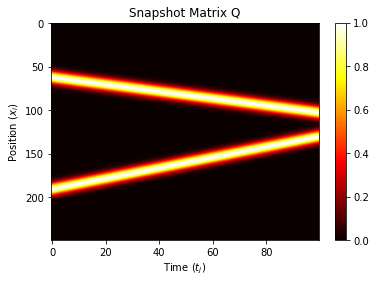

In [33]:
plt.imshow(Q, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [34]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = Q.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define a model

In [36]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=True)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag_embed((s > 0).to(dtype))[:s.size(0), :s.size(0)]
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output

In [37]:
class ShapeShiftNet(nn.Module):
    def __init__(self):
        super(ShapeShiftNet, self).__init__()
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 1)
        
        self.shift1_fc1 = nn.Linear(1, 32)
        self.shift1_fc2 = nn.Linear(32, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 1)
        
        self.shift2_fc1 = nn.Linear(1, 32)
        self.shift2_fc2 = nn.Linear(32, 1)

    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = torch.relu(self.shift1_fc1(t))
        shift1 = self.shift1_fc2(shift1)
        x_shifted1 = x + shift1
        f1 = torch.relu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = torch.relu(self.f1_fc2(f1))
        f1 = self.f1_fc3(f1)
        
        f1_without_shift = torch.relu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = torch.relu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.f1_fc3(f1_without_shift)
        
        # Pathway for f^2 and shift^2
        shift2 = torch.relu(self.shift2_fc1(t))
        shift2 = self.shift2_fc2(shift2)
        x_shifted2 = x + shift2
        f2 = torch.relu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = torch.relu(self.f2_fc2(f2))
        f2 = self.f2_fc3(f2)
        
        f2_without_shift = torch.relu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = torch.relu(self.f1_fc2(f2_without_shift))
        f2_without_shift = self.f1_fc3(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift


In [35]:
model = ShapeShiftNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
def total_variation(x, t, f, shift, f_without_shift):
    shift = shift + 1e-8
    TV = torch.mean(torch.abs(f_without_shift - f) / torch.abs(shift))

    return TV


In [24]:
num_epochs = 1000

for epoch in range(num_epochs+1):
    for batch_inputs, batch_targets in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        optimizer.zero_grad()
        f1_pred, f2_pred, shift1_pred, shift2_pred, f1_pred_nos, f2_pred_nos = model(x, t)
        TV1 = total_variation(x,t,f1_pred, shift1_pred, f1_pred_nos)
        TV2 = total_variation(x,t,f2_pred, shift2_pred, f2_pred_nos)
        loss = torch.norm(batch_targets - f1_pred - f2_pred, 'fro')**2 + TV1 + TV2 + NuclearNormAutograd.apply(f1_pred_nos) + NuclearNormAutograd.apply(f2_pred_nos)
        loss.backward()
        optimizer.step()
                
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Epoch 0/1000, Loss: 4.538077354431152
Epoch 100/1000, Loss: 0.22577369213104248
Epoch 200/1000, Loss: 0.1069537103176117
Epoch 300/1000, Loss: 0.48589420318603516
Epoch 400/1000, Loss: 0.010563302785158157
Epoch 500/1000, Loss: 0.01758178137242794
Epoch 600/1000, Loss: 0.007094475440680981
Epoch 700/1000, Loss: 0.0035715997219085693
Epoch 800/1000, Loss: 0.009878195822238922



KeyboardInterrupt



In [25]:
with torch.no_grad():
    f1_output, f2_output, _,_,_,_ = model(inputs_tensor[:, 0:1], inputs_tensor[:, 1:2])

combined = f1_output + f2_output
Q_tilde = combined.view(Nx, Nt).numpy()
f1_matrix = f1_output.view(Nx, Nt).numpy()
f2_matrix = f2_output.view(Nx, Nt).numpy()

Text(0, 0.5, 'Position ($x_i$)')

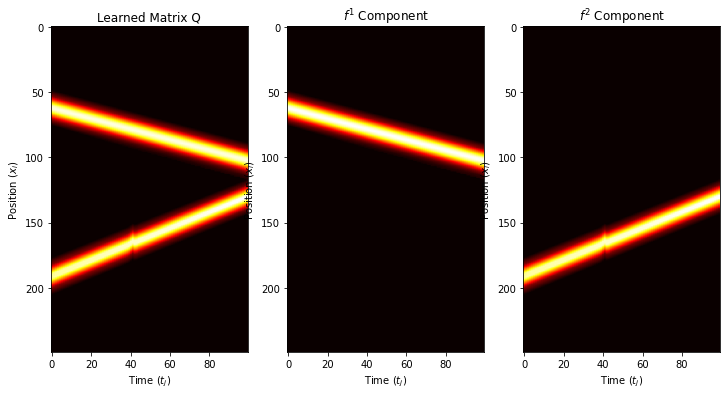

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

#Qtilde
axs[0].imshow(Q_tilde, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')